## Elephant Cross Correlation Test

There may be an issue with the scaling of cross correlation at least for single pairs using `elephant.signal_processing.cross_correlation_function()` tested using the example below


In [1]:
%load_ext watermark
%matplotlib notebook

import numpy
import numpy as np
import matplotlib.pyplot as plt

import elephant
from elephant import signal_processing

import neo
from quantities import Hz, mV, sec, ms

%watermark -v -m -p numpy,scipy,neo,elephant

CPython 3.5.2
IPython 7.8.0

numpy 1.17.3
scipy 1.3.1
neo 0.7.2
elephant 0.6.3

compiler   : GCC 5.4.0 20160609
system     : Linux
release    : 4.4.0-165-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


### Example

The example problem converted from matlab (see http://www.mechanicalvibration.com/Using_cross_correlation_lin.html).

In [2]:
fs = 100.0
t = np.arange(0.0, 10.0, 1/fs)
f = 1

In [3]:
sig1 = 1.0 * np.sin(2.0*np.pi*f*t) + 0.15 * np.sin(2.0*np.pi*4.0*f*t)
sig2 = 1.2 * np.sin(2.0*np.pi*f*t + np.pi/2.0) +  0.15 * np.sin(2.0*np.pi*3.0*f*t)

<IPython.core.display.Javascript object>


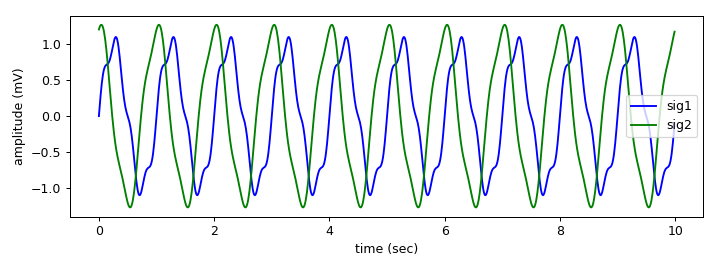

In [4]:
plt.figure(figsize=(8,3))
plt.plot(t, sig1,'b-', label='sig1')
plt.plot(t, sig2, 'g-', label='sig2')
plt.xlabel('time (sec)')
plt.ylabel('amplitude (mV)')
plt.legend()
plt.tight_layout()

### Numpy Version

Performed cross correlation of these two signals using `numpy.correlate()` and, to match matlab used same normalization used in `matlab.xcorr()` (https://www.mathworks.com/matlabcentral/answers/5275-algorithm-for-coeff-scaling-of-xcorr):

In [5]:
cxx = np.correlate(sig1, sig2, "full")/np.sqrt(np.sum(np.abs(sig1)**2)*np.sum(np.abs(sig2)**2))

In [6]:
tx = np.arange(-t[-1],t[-1]+(0.5/fs),1/fs)

The cross correlation plot looks similar to original matlab example:

<IPython.core.display.Javascript object>


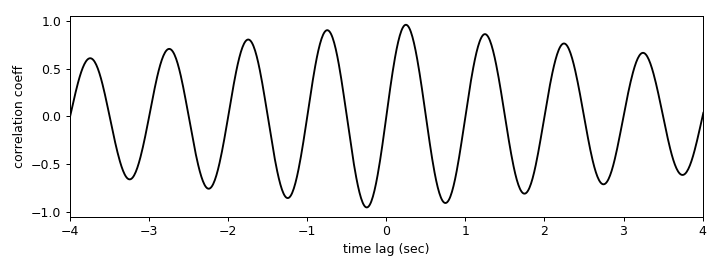

In [7]:
plt.figure(figsize=(8,3))
plt.plot(tx, cxx, 'k-')
plt.xlim(-4,4)
plt.xlabel('time lag (sec)')
plt.ylabel('correlation coeff')
plt.tight_layout()

Use peak of cross-correlation to find time shift between sig1 and sig2, which was 0.25 in original matlab example:

In [8]:
tshift = tx[np.argmax(cxx)]
tshift

0.2499999999997815

Now replot sig2 using this time shift to check signals align:

<IPython.core.display.Javascript object>


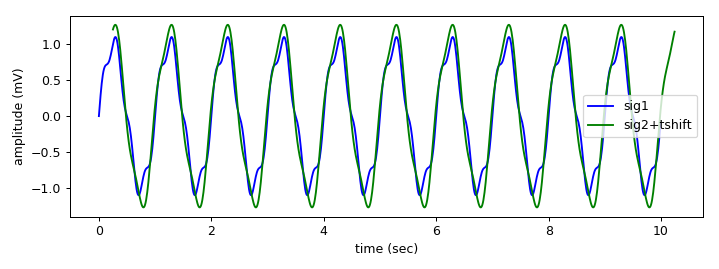

In [9]:
plt.figure(figsize=(8,3))
plt.plot(t, sig1,'b-', label='sig1')
plt.plot(t+tshift, sig2, 'g-', label='sig2+tshift')
plt.xlabel('time (sec)')
plt.ylabel('amplitude (mV)')
plt.legend()
plt.tight_layout()

### Elephant Version

`elephant.signal_processing.cross_correlation_function()` does not give quite the same results as `numpy.correlate()` function

In [10]:
x = np.vstack([sig1,sig2]).T
x.shape

(1000, 2)

In [11]:
signal = neo.AnalogSignal(x, units='mV', t_start=0.*sec, sampling_rate=fs*Hz, dtype=float)

In [12]:
rho = elephant.signal_processing.cross_correlation_function(signal, [0,1])


<IPython.core.display.Javascript object>


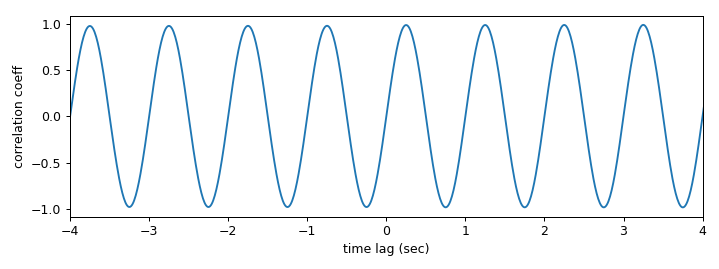

In [13]:
plt.figure(figsize=(8,3))
plt.plot(rho.times, rho)
plt.xlabel('time lag (sec)')
plt.ylabel('correlation coeff')
plt.xlim(-4,4)
plt.tight_layout()

#### Differences...

Examined `cross_correlation_function()` code (https://github.com/NeuralEnsemble/elephant/blob/master/elephant/signal_processing.py). Essentially it performs an FFT convolution of normalized signals, where tau is the time lags and xcorr is correlation coefficient: 

In [14]:
from scipy.signal import fftconvolve
from scipy.stats import zscore

zsig1 = zscore(sig1)
zsig2 = zscore(sig2)

nt = np.shape(zsig1)[0]

tau = (np.arange(nt) - nt//2)

xcorr = fftconvolve(zsig1, zsig2[::-1], mode='same')
    
# did not perform scaling of xcorr:
# xcorr = xcorr / npm.repmat((nt-abs(tau)), nch, 1).T

The unscaled "correlation coefficient" appears same as numpy correlate():

<IPython.core.display.Javascript object>


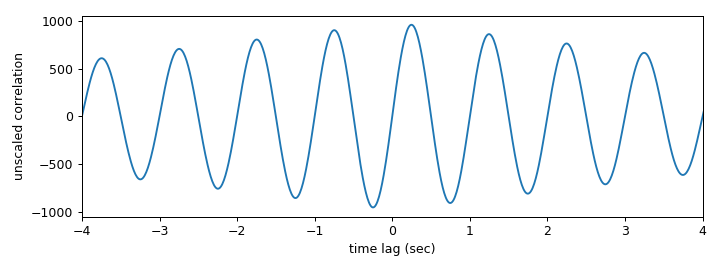

In [15]:
plt.figure(figsize=(8,3))
plt.plot(tau/fs, xcorr)
plt.xlabel('time lag (sec)')
plt.ylabel('unscaled correlation')
plt.xlim(-4,4)
plt.tight_layout()

The time shift matches numpy result too:

In [16]:
tshift = tau[np.argmax(xcorr)]/fs
tshift

0.25

#### Conclusion

This suggests at least for single pairs there may be a problem in the scaling of xcorr. This is scaling step for a single channel case (one pair):

In [17]:
nch = 1
R = np.matlib.repmat((nt-abs(tau)), nch, 1).T

In [18]:
R.shape

(1000, 1)

In [19]:
np.squeeze(R)

array([ 500,  501,  502,  503,  504,  505,  506,  507,  508,  509,  510,
        511,  512,  513,  514,  515,  516,  517,  518,  519,  520,  521,
        522,  523,  524,  525,  526,  527,  528,  529,  530,  531,  532,
        533,  534,  535,  536,  537,  538,  539,  540,  541,  542,  543,
        544,  545,  546,  547,  548,  549,  550,  551,  552,  553,  554,
        555,  556,  557,  558,  559,  560,  561,  562,  563,  564,  565,
        566,  567,  568,  569,  570,  571,  572,  573,  574,  575,  576,
        577,  578,  579,  580,  581,  582,  583,  584,  585,  586,  587,
        588,  589,  590,  591,  592,  593,  594,  595,  596,  597,  598,
        599,  600,  601,  602,  603,  604,  605,  606,  607,  608,  609,
        610,  611,  612,  613,  614,  615,  616,  617,  618,  619,  620,
        621,  622,  623,  624,  625,  626,  627,  628,  629,  630,  631,
        632,  633,  634,  635,  636,  637,  638,  639,  640,  641,  642,
        643,  644,  645,  646,  647,  648,  649,  6

So it appears that xcorr is scaled by abs(lag) which compensates for decay from peak correlation:

<IPython.core.display.Javascript object>


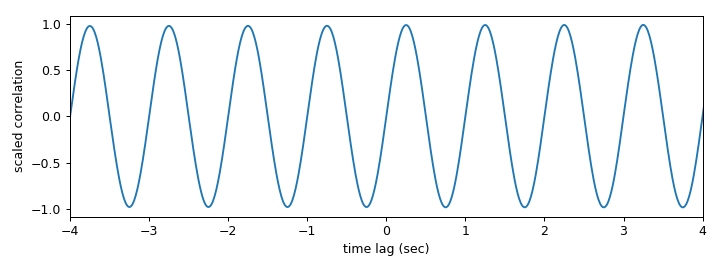

In [20]:
plt.figure(figsize=(8,3))
plt.plot(tau/fs, xcorr/np.squeeze(R))
plt.xlabel('time lag (sec)')
plt.ylabel('scaled correlation')
plt.xlim(-4,4)
plt.tight_layout()

Whereas dividing by sample length appears to scale correlation identically to numpy version:

<IPython.core.display.Javascript object>


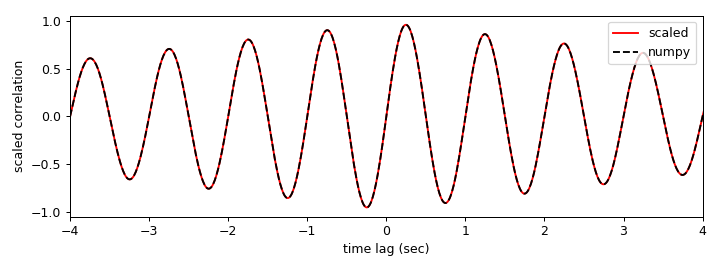

In [21]:
plt.figure(figsize=(8,3))
plt.plot(tau/fs, xcorr/nt,'r-',label='scaled')
plt.plot(tx, cxx, 'k--', label='numpy')
plt.xlabel('time lag (sec)')
plt.ylabel('scaled correlation')
plt.xlim(-4,4)
plt.legend()
plt.tight_layout()